<a href="https://colab.research.google.com/github/HarshESC/TalkData-Mobile-Demographics/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn.svm import SVC

from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')



In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/"
%cd "/content/gdrive/My Drive/Final Capstone"

Mounted at /content/gdrive
/content/gdrive/My Drive/Final Capstone


# Small EDA

In [ ]:
master_df = pd.read_csv("master_clean.csv")

master_df.head()

,event_id,app_id,is_active,device_id,251,252,253,254,256,262,263,302,303,306,318,326,405,406,407,548,549,551,558,562,564,565,566,english_phone_brand_asus,english_phone_brand_coolpad,english_phone_brand_hammer,english_phone_brand_huawei,english_phone_brand_lshi,english_phone_brand_meizu,english_phone_brand_oppo,english_phone_brand_qiku,english_phone_brand_samsung,english_phone_brand_vivo,english_phone_brand_xiaomi,device_model_Galaxy Note 3,device_model_Galaxy Note 4,device_model_Galaxy S5,device_model_Galaxy S6,device_model_MI 3,device_model_MI 4,device_model_MX4,device_model_MX4 Pro,device_model_MX5,device_model_Mate 7,device_model_P8 Lite,device_model_P8max,device_model_R7 Plus,device_model_U3,device_model_X5SL,device_model_Z1,device_model_ZenFone 2,device_model_note顶配版,device_model_坚果手机,device_model_大神Note3,device_model_小米4C,device_model_小米note,device_model_红米2,device_model_红米2A,device_model_红米Note2,device_model_红米Note3,device_model_红米note,device_model_荣耀3C,device_model_荣耀6,device_model_荣耀6 Plus,device_model_荣耀7,device_model_荣耀7i,device_model_荣耀X2,device_model_荣耀畅玩4C,device_model_荣耀畅玩5X,device_model_超级手机1,device_model_超级手机1 Pro,device_model_超级手机1s,device_model_青春版,device_model_魅蓝NOTE,device_model_魅蓝metal,num_group
0,198,-8807740666788515175,0,6984152891252102027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,198,-7415261454408512527,0,6984152891252102027,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,198,-6538188762242952077,1,6984152891252102027,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,198,-6493194103110420302,0,6984152891252102027,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,198,-6349602347932703147,0,6984152891252102027,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [ ]:
# Dropping AppID as I don't think it will be helpful for our question
master_df = master_df.drop(columns=["app_id"])


In [ ]:

master_df["num_group"].value_counts()


5     2974
4     2697
3     1415
1     1292
2      960
11     863
10     687
0      638
9      405
8      283
6      194
7      143
Name: num_group, dtype: int64

In [ ]:
numerical_columns = ["device_id", "event_id"]


# Select K Best

In [ ]:
# splitting up the data and choosing num_group as target variable
X = master_df.drop(columns=["num_group"])
y = master_df["num_group"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)


In [ ]:
# set up preprocessing for pipeline (used to scale features)
preprocessing = ColumnTransformer(
    [("scale", StandardScaler(), numerical_columns),], remainder="passthrough",
)



## Random Forest Classifier

In [ ]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("rf", RandomForestClassifier())], verbose=True
)

pipeline.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.2s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['device_id', 'event_id'])])),
                ('rf', RandomForestClassifier())],
         verbose=True)

Grid search

In [ ]:
# Max depth of 50 provides a better score, this is much better than the previous score of around 0.2.
# To improve score suggest increasing max depth even more
grid = {
    "rf__max_depth": [50, 70, 90, 110],
    "rf__n_estimators": [1, 10, 100],
    "rf__min_samples_leaf": [1, 3, 5, 7],
    "rf__criterion": ["gini"],
}

model = GridSearchCV(pipeline, grid, n_jobs=-1, verbose=True)
model.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.1s


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['device_id',
                                                                          'event_id'])])),
                                       ('rf', RandomForestClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini'],
                         'rf__max_depth': [50, 70, 90, 110],
                         'rf__min_samples_leaf': [1, 3, 5, 7],
                         'rf__n_estimators': [1, 10, 100]},
             verbose=True)

In [ ]:
model.best_params_


{'rf__criterion': 'gini',
 'rf__max_depth': 110,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 100}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")


Train score: 1.0
Test score: 0.9872560732775787


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)




,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,125,0,0,1,1,0,0,0,0,1,0,0
Actual M23-26,1,255,0,0,1,0,0,0,0,1,0,0
Actual M27-28,0,0,189,1,0,2,0,0,0,0,0,0
Actual M29-31,5,0,0,276,0,1,0,0,0,0,0,1
Actual M32-38,0,0,0,0,535,2,0,0,1,0,0,1
Actual M39+,0,1,1,1,1,590,0,0,0,0,1,0
Actual F23-,0,0,0,0,0,0,39,0,0,0,0,0
Actual F24-26,0,0,0,0,2,0,0,26,0,0,1,0
Actual F27-28,0,0,0,0,0,0,0,0,57,0,0,0
Actual F29-32,0,0,0,0,0,0,0,0,0,81,0,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       128
           1       1.00      0.99      0.99       258
           2       0.99      0.98      0.99       192
           3       0.99      0.98      0.98       283
           4       0.99      0.99      0.99       539
           5       0.99      0.99      0.99       595
           6       1.00      1.00      1.00        39
           7       1.00      0.90      0.95        29
           8       0.98      1.00      0.99        57
           9       0.98      1.00      0.99        81
          10       0.99      0.99      0.99       137
          11       0.98      0.98      0.98       173

    accuracy                           0.99      2511
   macro avg       0.99      0.98      0.98      2511
weighted avg       0.99      0.99      0.99      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.9902451972900056

# K Nearest Neighbor 


In [ ]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("knn", KNeighborsClassifier())], verbose=True
)

pipeline.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['device_id', 'event_id'])])),
                ('knn', KNeighborsClassifier())],
         verbose=True)

In [ ]:
grid = {
    "knn__n_neighbors": [50, 100, 150],
    "knn__weights": ["distance"],
    "knn__leaf_size": [1, 10, 20],
}

model = GridSearchCV(pipeline, grid, n_jobs=-1, verbose=2, cv=2)
model.fit(X_train, y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['device_id',
                                                                          'event_id'])])),
                                       ('knn', KNeighborsClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'knn__leaf_size': [1, 10, 20],
                         'knn__n_neighbors': [50, 100, 150],
                         'knn__weights': ['distance']},
             verbose=2)

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 0.8622062923138192


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)




,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,109,1,0,2,8,8,0,0,0,0,0,0
Actual M23-26,4,228,0,1,5,13,0,0,0,2,4,1
Actual M27-28,1,5,162,2,3,18,0,0,0,0,0,1
Actual M29-31,11,3,0,234,16,17,0,0,1,0,0,1
Actual M32-38,0,0,0,8,480,42,0,2,0,3,2,2
Actual M39+,2,1,1,2,19,553,0,2,0,4,11,0
Actual F23-,0,0,0,1,3,4,31,0,0,0,0,0
Actual F24-26,0,0,0,0,1,4,0,24,0,0,0,0
Actual F27-28,0,6,0,3,0,6,0,0,42,0,0,0
Actual F29-32,0,0,2,0,4,14,0,0,0,61,0,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       128
           1       0.93      0.88      0.90       258
           2       0.97      0.84      0.90       192
           3       0.91      0.83      0.87       283
           4       0.86      0.89      0.88       539
           5       0.77      0.93      0.84       595
           6       0.94      0.79      0.86        39
           7       0.83      0.83      0.83        29
           8       0.98      0.74      0.84        57
           9       0.86      0.75      0.80        81
          10       0.84      0.79      0.82       137
          11       0.96      0.77      0.86       173

    accuracy                           0.86      2511
   macro avg       0.89      0.82      0.85      2511
weighted avg       0.87      0.86      0.86      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.9052496888001079

In [ ]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("dtc", DecisionTreeClassifier())], verbose=True
)

pipeline.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing dtc, total=   0.0s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['device_id', 'event_id'])])),
                ('dtc', DecisionTreeClassifier())],
         verbose=True)

In [ ]:
# Max depth of 50 provides a better score, this is much better than the previous score of around 0.2.
# To improve score suggest increasing max depth even more
grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}


model = GridSearchCV(DecisionTreeClassifier(random_state=42), grid, verbose=1, cv=3)


In [ ]:
model.fit(X_train, y_train)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [ ]:
model.best_params_


{'max_leaf_nodes': 99, 'min_samples_split': 2}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.8231075697211155
Test score: 0.8231780167264038


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)




,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,97,0,5,7,8,0,0,0,0,0,7,4
Actual M23-26,0,243,0,0,8,7,0,0,0,0,0,0
Actual M27-28,0,0,138,13,14,9,9,0,0,0,0,9
Actual M29-31,8,0,0,224,9,35,0,0,0,0,7,0
Actual M32-38,0,0,0,15,482,42,0,0,0,0,0,0
Actual M39+,0,0,3,27,17,548,0,0,0,0,0,0
Actual F23-,0,0,0,0,12,0,27,0,0,0,0,0
Actual F24-26,0,0,0,0,0,0,0,29,0,0,0,0
Actual F27-28,0,13,0,14,11,0,0,0,19,0,0,0
Actual F29-32,0,0,0,0,10,6,0,13,0,52,0,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       128
           1       0.93      0.94      0.94       258
           2       0.95      0.72      0.82       192
           3       0.71      0.79      0.75       283
           4       0.83      0.89      0.86       539
           5       0.82      0.92      0.87       595
           6       0.75      0.69      0.72        39
           7       0.69      1.00      0.82        29
           8       0.54      0.33      0.41        57
           9       0.62      0.64      0.63        81
          10       0.87      0.66      0.75       137
          11       0.90      0.68      0.78       173

    accuracy                           0.82      2511
   macro avg       0.79      0.75      0.76      2511
weighted avg       0.83      0.82      0.82      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.8675760593619294

# Gradient Boosting 

In [ ]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("gb", GradientBoostingClassifier())], verbose=True
)

pipeline.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing gb, total=  21.1s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['device_id', 'event_id'])])),
                ('gb', GradientBoostingClassifier())],
         verbose=True)

In [ ]:
grid = {'gb__n_estimators': [100], 
          'gb__max_depth': [5],
          'gb__loss': ['deviance']}

model = GridSearchCV(pipeline, grid, verbose=1, cv=3)
model.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing gb, total=  20.8s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing gb, total=  20.5s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing gb, total=  20.5s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing gb, total=  30.6s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['device_id',
                                                                          'event_id'])])),
                                       ('gb', GradientBoostingClassifier())],
                                verbose=True),
             param_grid={'gb__loss': ['deviance'], 'gb__max_depth': [5],
                         'gb__n_estimators': [100]},
             verbose=1)

In [ ]:
model.best_params_

{'gb__loss': 'deviance', 'gb__max_depth': 5, 'gb__n_estimators': 100}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 1.0


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)


,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,128,0,0,0,0,0,0,0,0,0,0,0
Actual M23-26,0,258,0,0,0,0,0,0,0,0,0,0
Actual M27-28,0,0,192,0,0,0,0,0,0,0,0,0
Actual M29-31,0,0,0,283,0,0,0,0,0,0,0,0
Actual M32-38,0,0,0,0,539,0,0,0,0,0,0,0
Actual M39+,0,0,0,0,0,595,0,0,0,0,0,0
Actual F23-,0,0,0,0,0,0,39,0,0,0,0,0
Actual F24-26,0,0,0,0,0,0,0,29,0,0,0,0
Actual F27-28,0,0,0,0,0,0,0,0,57,0,0,0
Actual F29-32,0,0,0,0,0,0,0,0,0,81,0,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       258
           2       1.00      1.00      1.00       192
           3       1.00      1.00      1.00       283
           4       1.00      1.00      1.00       539
           5       1.00      1.00      1.00       595
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        57
           9       1.00      1.00      1.00        81
          10       1.00      1.00      1.00       137
          11       1.00      1.00      1.00       173

    accuracy                           1.00      2511
   macro avg       1.00      1.00      1.00      2511
weighted avg       1.00      1.00      1.00      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

1.0

# PCA Models

In [ ]:
# Since I am performing pca its necessary to standardize data and fit it to data frame.
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Computing the principal components
pca = PCA()
X_pca = pca.fit_transform(X_train_std)


In [ ]:
# I plan to use the amount of components that add up to 90% variance.
n_components = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.90)
X_pca = X_pca[:, :n_components]


In [ ]:
# check to see the amount of components being used
n_components


48

# Random Forest Classifier 

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components)),
        ("rf", RandomForestClassifier()),
    ]
)
pipeline = pipeline.fit(X_train, y_train)


In [ ]:
grid = {
    "rf__max_depth": [90, 110, 130],
    "rf__n_estimators": [1, 10, 100],
    "rf__min_samples_leaf": [1, 3, 5, 7],
    "rf__criterion": ["gini"],
}

model = GridSearchCV(pipeline, grid, n_jobs=-1, cv=2, verbose=2)
model.fit(X_train, y_train)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=48)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini'],
                         'rf__max_depth': [90, 110, 130],
                         'rf__min_samples_leaf': [1, 3, 5, 7],
                         'rf__n_estimators': [1, 10, 100]},
             verbose=2)

In [ ]:
model.best_params_


{'rf__criterion': 'gini',
 'rf__max_depth': 90,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 100}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9930278884462151
Test score: 0.8056551174830745


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)


,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,95,3,0,4,6,18,0,0,0,2,0,0
Actual M23-26,4,221,4,5,7,10,0,0,0,2,2,3
Actual M27-28,3,6,163,1,5,8,0,0,0,0,1,5
Actual M29-31,7,8,2,214,14,29,1,0,2,2,2,2
Actual M32-38,3,0,3,16,453,40,0,1,2,3,5,13
Actual M39+,14,12,6,12,21,502,0,5,3,5,11,4
Actual F23-,0,0,0,0,4,3,30,0,0,0,2,0
Actual F24-26,0,0,0,0,1,2,0,25,0,0,1,0
Actual F27-28,0,5,1,2,2,5,0,0,39,0,0,3
Actual F29-32,1,4,1,0,6,14,0,0,0,54,1,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       128
           1       0.84      0.86      0.85       258
           2       0.91      0.85      0.88       192
           3       0.82      0.76      0.79       283
           4       0.82      0.84      0.83       539
           5       0.77      0.84      0.80       595
           6       0.94      0.77      0.85        39
           7       0.78      0.86      0.82        29
           8       0.78      0.68      0.73        57
           9       0.75      0.67      0.71        81
          10       0.76      0.75      0.75       137
          11       0.79      0.72      0.75       173

    accuracy                           0.81      2511
   macro avg       0.81      0.78      0.79      2511
weighted avg       0.81      0.81      0.81      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.8794874039412083

# KNN Classifier

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components)),
        ("knn", KNeighborsClassifier()),
    ]
)
pipeline = pipeline.fit(X_train, y_train)


In [ ]:
grid = {
    "knn__n_neighbors": [50, 100, 150],
    "knn__weights": ["distance"],
    "knn__leaf_size": [1, 10, 20],
}

model = GridSearchCV(pipeline, grid, n_jobs=-1, cv=2, verbose=2)
model.fit(X_train, y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=48)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__leaf_size': [1, 10, 20],
                         'knn__n_neighbors': [50, 100, 150],
                         'knn__weights': ['distance']},
             verbose=2)

In [ ]:
model.best_params_


{'knn__leaf_size': 10, 'knn__n_neighbors': 150, 'knn__weights': 'distance'}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9955179282868526
Test score: 0.7678215850258862


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)


,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,82,4,0,4,13,21,0,3,0,1,0,0
Actual M23-26,4,201,1,1,18,26,0,0,0,3,4,0
Actual M27-28,1,8,143,4,6,23,0,0,0,0,3,4
Actual M29-31,6,12,0,195,27,43,0,0,0,0,0,0
Actual M32-38,1,0,0,5,461,58,0,1,0,8,1,4
Actual M39+,11,14,2,6,34,515,0,0,0,7,6,0
Actual F23-,0,1,0,1,3,6,28,0,0,0,0,0
Actual F24-26,2,0,0,0,0,5,0,22,0,0,0,0
Actual F27-28,0,6,0,1,4,5,0,0,37,0,1,3
Actual F29-32,0,8,4,6,3,15,0,0,0,45,0,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       128
           1       0.78      0.78      0.78       258
           2       0.94      0.74      0.83       192
           3       0.87      0.69      0.77       283
           4       0.77      0.86      0.81       539
           5       0.67      0.87      0.75       595
           6       0.90      0.72      0.80        39
           7       0.85      0.76      0.80        29
           8       0.93      0.65      0.76        57
           9       0.64      0.56      0.60        81
          10       0.83      0.66      0.74       137
          11       0.91      0.62      0.74       173

    accuracy                           0.77      2511
   macro avg       0.82      0.71      0.76      2511
weighted avg       0.78      0.77      0.77      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)
multiclass_roc_auc_score(y_test, y_pred, average="macro")

In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.8441237158181988

# Gradient Boosting

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components)),
        ("gb", GradientBoostingClassifier()),
    ]
)
pipeline = pipeline.fit(X_train, y_train)


In [ ]:
grid = {'gb__n_estimators': [100], 
          'gb__max_depth': [5],
          'gb__loss': ['deviance']}

model = GridSearchCV(pipeline, grid, verbose=1, cv=3)
model.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=48)),
                                       ('gb', GradientBoostingClassifier())]),
             param_grid={'gb__loss': ['deviance'], 'gb__max_depth': [5],
                         'gb__n_estimators': [100]},
             verbose=1)

In [ ]:
model.best_params_  

{'gb__loss': 'deviance', 'gb__max_depth': 5, 'gb__n_estimators': 100}

In [ ]:
# Model still appears to be extremely overfitting
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")


Train score: 0.9058764940239044
Test score: 0.7793707686180804


In [ ]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=[
        "Actual M22-",
        "Actual M23-26",
        "Actual M27-28",
        "Actual M29-31",
        "Actual M32-38",
        "Actual M39+",
        "Actual F23-",
        "Actual F24-26",
        "Actual F27-28",
        "Actual F29-32",
        "Actual F33-42",
        "Actual F43+",
    ],
    columns=[
        "Predicted M22-",
        "Predicted M23-26",
        "Predicted M27-28",
        "Predicted M29-31",
        "Predicted M32-38",
        "Predicted M39+",
        "Predicted F23-",
        "Predicted F24-26",
        "Predicted F27-28",
        "Predicted F29-32",
        "Predicted F33-42",
        "Predicted F43+",
    ],
)
con_mat.style.background_gradient(axis=None)


,Predicted M22-,Predicted M23-26,Predicted M27-28,Predicted M29-31,Predicted M32-38,Predicted M39+,Predicted F23-,Predicted F24-26,Predicted F27-28,Predicted F29-32,Predicted F33-42,Predicted F43+
Actual M22-,92,4,4,4,4,18,0,0,0,2,0,0
Actual M23-26,3,212,2,8,7,20,0,0,2,1,1,2
Actual M27-28,4,7,158,3,3,11,0,0,0,1,1,4
Actual M29-31,7,7,2,194,21,44,1,1,1,0,2,3
Actual M32-38,1,3,0,20,439,57,0,2,1,1,4,11
Actual M39+,13,8,5,12,25,502,0,5,3,6,14,2
Actual F23-,0,0,0,1,4,6,28,0,0,0,0,0
Actual F24-26,0,0,0,0,2,3,0,24,0,0,0,0
Actual F27-28,0,5,0,2,1,7,0,0,40,0,0,2
Actual F29-32,0,5,1,3,4,10,0,0,0,56,2,0


In [ ]:
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       128
           1       0.84      0.82      0.83       258
           2       0.89      0.82      0.86       192
           3       0.77      0.69      0.73       283
           4       0.82      0.81      0.82       539
           5       0.69      0.84      0.76       595
           6       0.93      0.72      0.81        39
           7       0.69      0.83      0.75        29
           8       0.78      0.70      0.74        57
           9       0.81      0.69      0.75        81
          10       0.79      0.72      0.75       137
          11       0.82      0.66      0.73       173

    accuracy                           0.78      2511
   macro avg       0.80      0.75      0.77      2511
weighted avg       0.79      0.78      0.78      2511



In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [ ]:
multiclass_roc_auc_score(y_test, y_pred, average="macro")

0.8647379098265993

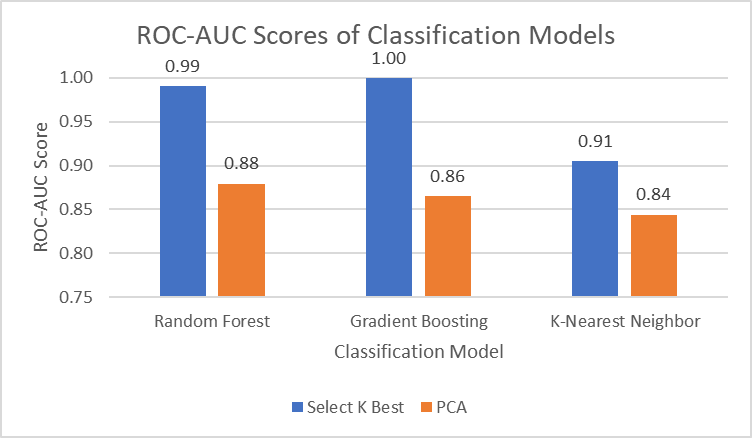